# Image Captioning

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import spacy
import re
import random
import json

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

In [3]:
extracted_data_train_dir = 'extracted_data/train/'
extracted_data_test_dir = 'extracted_data/test/'

In [4]:
def load_json(file):
    with open(file, 'r') as f1:
        return json.loads(f1.read())

In [5]:
train_captions = load_json(extracted_data_train_dir + 'captions.json')
train_image_paths = load_json(extracted_data_train_dir + 'image_paths.json')

In [6]:
train_captions[55]

'<START> A bathroom with a TV near the mirror <END>'

In [7]:
train_image_paths[55]

'mscoco/train/img/COCO_train2014_000000028149'

In [8]:
# train_captions = [x[8:] for x in train_captions]

In [9]:
print(train_image_paths[0], train_captions[0])

mscoco/train/img/COCO_train2014_000000318556 <START> A very clean and well decorated empty bathroom <END>


## Building a vocabulary

In [10]:
from Vocabulary import Vocabulary

In [11]:
max_vocab_size = 5000

In [12]:
from collections import defaultdict

word_freq = defaultdict(int)
word_to_idx = {"<pad>": 0, "<start>": 1, "<end>": 2, '<unk>': 3}
idx_to_word = {0: "<pad>", 1: "<start>", 2: "<end>", 3: '<unk>'}

unk_idx = word_to_idx['<unk>']

In [13]:
def preprocess_caption(caption):
    return caption.lower().split()

In [14]:
for caption in train_captions:
    caption = preprocess_caption(caption)
    for word in caption:
        if word in word_freq: word_freq[word] += 1
        else: word_freq[word] = 1

word_freq.pop("<start>", None)
word_freq.pop("<end>", None)

249454

In [15]:
start_idx = len(word_to_idx)
print(start_idx)

# get top K words
for word in sorted(word_freq, key=word_freq.get, reverse=True):
    word_to_idx[word] = start_idx
    idx_to_word[start_idx] = word
    start_idx += 1
    if start_idx >= max_vocab_size: break

len(word_to_idx)

4


5000

In [16]:
def encode_sentence(sentence):
    return [word_to_idx.get(x, unk_idx) for x in preprocess_caption(sentence)]

def decode_sentence(indices):
    return " ".join([idx_to_word.get(x, '<unk>') for x in indices])

In [17]:
sentence = 'This is not fun'
encoded = encode_sentence(sentence)
decoded = decode_sentence(encoded)

print(encoded)
print(decoded)

[132, 11, 665, 1931]
this is not fun


In [18]:
train_vocab = Vocabulary(train_captions, max_vocab_size)

In [19]:
print(train_vocab.encoded_captions[0])
print(train_vocab.decode_sentence(train_vocab.encoded_captions[0]))
print(train_captions[0])

[1, 4, 125, 473, 10, 742, 480, 230, 38, 2]
<start> a very clean and well decorated empty bathroom <end>
<START> A very clean and well decorated empty bathroom <END>


Create encoded captions for each caption in training

In [20]:
encoded_captions_train = [encode_sentence(x) for x in train_captions]

print(encoded_captions_train[:1])
print(decode_sentence(encoded_captions_train[0]))
print(train_captions[:1])

[[1, 4, 125, 473, 10, 742, 480, 230, 38, 2]]
<start> a very clean and well decorated empty bathroom <end>
['<START> A very clean and well decorated empty bathroom <END>']


In [21]:
len(encoded_captions_train)

249454

In [22]:
decode_sentence(encoded_captions_train[55])

'<start> a bathroom with a tv near the mirror <end>'

## Create Dataset

In [23]:
from torch.utils.data import DataLoader
from MyDataset import MyDataset

In [24]:
from torch.nn.utils.rnn import pad_sequence
wat = [torch.tensor(x[1:], dtype=torch.int16) for x in train_vocab.encoded_captions]
padded = pad_sequence(wat).permute(1, 0)
print(len(padded))

249454


In [25]:
encoded_captions_train[55]

[1, 4, 38, 9, 4, 510, 31, 5, 195, 2]

In [26]:
train_vocab.encoded_captions[55]

[1, 4, 38, 9, 4, 510, 31, 5, 195, 2]

In [27]:
padded.shape

torch.Size([249454, 50])

In [28]:
padded[0]

tensor([  4, 125, 473,  10, 742, 480, 230,  38,   2,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0], dtype=torch.int16)

In [29]:
dataset = MyDataset(enc_captions=padded,
                    image_paths=train_image_paths,
                   data_dir=extracted_data_train_dir + 'vecs/')

In [30]:
# small dataste
dataset = MyDataset(enc_captions=padded[:32768],
                    image_paths=train_image_paths[:32768],
                   data_dir=extracted_data_train_dir + 'vecs/')

In [31]:
x = dataset[5]

In [32]:
dataset[0][0].shape

torch.Size([64, 2048])

In [33]:
dataloader = DataLoader(dataset=dataset, batch_size=256, 
                         num_workers = 0)

In [34]:
for idx, data in enumerate(dataloader):
    imgs, labels = data[0], data[1]
    print(idx, imgs.shape)
    print(labels[0].shape)
    print(labels[0].tolist())
    print(decode_sentence(labels[0].tolist()))
    break

0 torch.Size([256, 64, 2048])
torch.Size([50])
[4, 125, 473, 10, 742, 480, 230, 38, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
a very clean and well decorated empty bathroom <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


## Train model

In [35]:
from layers.Encoder import Encoder
from layers.Decoder import Decoder
from layers.Attention import Attention
from layers.End2End import End2End

In [36]:
# INPUT_DIM = len(SRC.vocab)
# OUTPUT_DIM = len(TRG.vocab)
DEC_EMB_DIM = 1024
ENC_INPUT = 2048
ENC_OUTPUT = 256 #256
DEC_HID_DIM = 512
DEC_OUTPUT = 512
ATTN_DIM = 512
EMB_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [37]:
PAD_IDX = 0

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [38]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [39]:
model = None
torch.cuda.empty_cache()

In [40]:
torch.cuda.empty_cache()
model = End2End(ENC_INPUT, ENC_OUTPUT, DEC_HID_DIM, DEC_OUTPUT,
               EMB_DIM, ATTN_DIM, train_vocab, criterion, device)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,602,889 trainable parameters


In [60]:
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
loss_plot = []

def train_step(batch, captions):
    
    batch_size = captions.shape[0]
    caption_length = captions.shape[1]
    
    optimizer.zero_grad()
    _, loss = model(batch, captions)
    
    loss.backward()
    optimizer.step()
    total_loss = (loss / int(caption_length))
    return loss, total_loss

In [61]:
import time

EPOCHS = 500

def train():
    model.train()
    for epoch in range(EPOCHS):
        start = time.time()
        total_loss = 0
        
        steps = 0
        for idx, batch in enumerate(dataloader):
            img_tensor, target, _ = batch[0], batch[1], batch[2]
            
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss.item()
#             return
            
            if idx % 500 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, idx, batch_loss.item() / int(target.shape[1])))
            steps += 1
            
        if epoch == 0:
            dataloader.dataset.set_use_cache(True)
            dataloader.num_workers = 3

        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / steps)

        print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                             total_loss/steps))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

train()

Epoch 1 Batch 0 Loss 1.1302
Epoch 1 Loss 1.991603
Time taken for 1 epoch 84.03380751609802 sec

Epoch 2 Batch 0 Loss 1.2303
Epoch 2 Loss 1.634886
Time taken for 1 epoch 85.20042419433594 sec

Epoch 3 Batch 0 Loss 1.2584
Epoch 3 Loss 1.545002
Time taken for 1 epoch 80.62184619903564 sec

Epoch 4 Batch 0 Loss 1.2436
Epoch 4 Loss 1.496869
Time taken for 1 epoch 79.50435876846313 sec

Epoch 5 Batch 0 Loss 1.2115
Epoch 5 Loss 1.470601
Time taken for 1 epoch 83.57751083374023 sec

Epoch 6 Batch 0 Loss 1.2012
Epoch 6 Loss 1.399813
Time taken for 1 epoch 81.21754169464111 sec

Epoch 7 Batch 0 Loss 1.1672
Epoch 7 Loss 1.349388
Time taken for 1 epoch 80.54397511482239 sec

Epoch 8 Batch 0 Loss 1.1962
Epoch 8 Loss 1.325614
Time taken for 1 epoch 83.10035920143127 sec

Epoch 9 Batch 0 Loss 1.1577
Epoch 9 Loss 1.277257
Time taken for 1 epoch 90.38400435447693 sec

Epoch 10 Batch 0 Loss 1.1414
Epoch 10 Loss 1.251700
Time taken for 1 epoch 81.55211210250854 sec

Epoch 11 Batch 0 Loss 1.1455
Epoch 11 

KeyboardInterrupt: 

In [137]:
torch.save(model.state_dict(), 'model')

In [141]:
model.load_state_dict(torch.load('model'))

<All keys matched successfully>

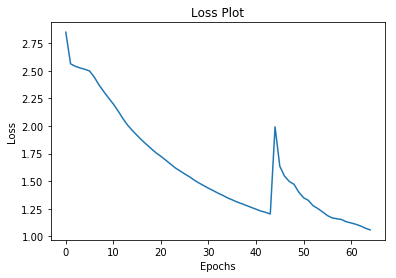

In [62]:
import matplotlib.pyplot as plt
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [63]:
im, cap, name = dataset[110]

In [64]:
cap

tensor([  70,  336,  314,    9,  120, 3319,    7,    4,  355,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0], dtype=torch.int16)

In [65]:
im = im.unsqueeze(0)
cap = cap.unsqueeze(0)
name

'extracted_data/train/vecs/COCO_train2014_000000568117'

In [66]:
im.shape

torch.Size([1, 64, 2048])

In [67]:
decode_sentence(cap.tolist()[0])

'three cats sleeping with their owners on a bed. <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [68]:
model.eval()

out = model.evaluate(im)
out

['a', 'woman', 'is', 'standing', 'in', 'the', '<unk>', '<end>']

In [69]:
out = model.evaluate(im, cap, True)
out

['a', 'people', '<end>']

In [70]:
cap.shape

torch.Size([1, 50])

## Other images

In [71]:
from PIL import Image
from data_preprocessing import *
import urllib.request
import io

In [72]:
img = preprocess_image_web('https://scontent.fbeg1-1.fna.fbcdn.net/v/t1.15752-9/106495264_270801397340750_5352596102031662927_n.jpg?_nc_cat=111&_nc_sid=b96e70&_nc_eui2=AeHUk7NrGbTNGQAAWPZuOseGdyXefbU8isZ3Jd59tTyKxlrvw8eGUmMqySImBZ4oCy2B2dfMEUR0-VKmJ7nQm1EF&_nc_ohc=f6VChx9r9cEAX_nfj3j&_nc_ht=scontent.fbeg1-1.fna&oh=7f53e6371c6af62fed5640d62a8df943&oe=5F225805')

In [73]:
img = img.reshape(1,64,2048)

In [74]:
out = model.evaluate(img)
out

['a',
 'woman',
 'is',
 'standing',
 'in',
 'a',
 'woman',
 'is',
 'standing',
 'in',
 'a',
 'woman',
 'is',
 'standing',
 'in',
 'a',
 'woman',
 'is',
 'standing',
 'in',
 'a',
 'woman',
 'is',
 'standing',
 'in',
 'a',
 'woman',
 'is',
 'standing',
 'in',
 'a',
 'woman',
 'is',
 'standing',
 'in',
 'a',
 'woman',
 'is',
 'standing',
 'in',
 'a',
 'woman',
 'is',
 'standing',
 'in',
 'a',
 'woman',
 'is',
 'standing',
 'in']